### Simulink Dilation

Thie notebook aims to demonstrate how a PYNQ board can be utilised to create a hardware accelerated (HWA) dilation filter. However, viewer discretion is advised as things may not go to plan :P

We are basing our filter of the design of Mr David Northcote that is available from ["StrathSDR's github"](https://github.com/strath-sdr/pynq_sobel).

### Image importing

So, as per the fact that we are comparing our results to OpenCV; we are forced to utilise a different method reading images in. Thankfully, Python has a library called "PIL" (Python Image Library) that we can use. Combining it with "numpy", pythons maths magic, we are able to read images in as matrix's. Also, we need OS to get directories and whatnot magic we need. Other imports we will need are is to import time, for you know? Timing how long it takes.

In [1]:
from PIL import Image
import os
import numpy as np
import time

After these imports, it's time to read an image. For consistency, and because MATLAB, we are going to use Zesty Peppers; which we will be just call Peppers. (Copyright The MathWorks, Inc.)

In [2]:
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir, os.pardir))
# parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
# Since the image we want is in the parent dir to make things neater
image_raw = Image.open(os.path.join(parent_dir, 'Peppers.jpg'))

It is important to note that we can use any image, as long as they are a standard 1920x180p, 32-bit image with a standard RGB colour range. Sorry any HSV lovers. To ensure this, let's force you to follow it (as well as some other shenanigans like padding the image and generating an array).

In [3]:
img_size = (1920,1080)

# Resize and force to RGB colours
img = image_raw.resize(img_size).convert('RGB')

# Interpret as a 3D array of bytes
img_arr = np.array(img, dtype=np.uint8)

# Add extra padding to erode edge bits
img_arr_padded = np.pad(img_arr, ((1,1),(1,1),(0,0)), 'symmetric')

Quick info dump for you; 'uintx' refers to casting x to the number of bytes the stream is allowed to be. It's very important

### PL Business
Remember when I said we imported everything we need?

Yeah I lied.

Time to import more. What we need to import now is overlay and allocate from PYNQ. What they do is allow us to allocate a buffer size (set buffer variable without giving it data) as well as being able to call our amazing .bit and .hwh to work for us.

In [4]:
from pynq import Overlay
from pynq import allocate

ol = Overlay("dilation.bit")

We can show you what is in the overlay, but we won't (just kidding).

In [5]:
ol.ip_dict

{'axi_dma_0': {'fullpath': 'axi_dma_0',
  'type': 'xilinx.com:ip:axi_dma:7.1',
  'bdtype': None,
  'state': None,
  'addr_range': 65536,
  'phys_addr': 1077936128,
  'mem_id': 'S_AXI_LITE',
  'memtype': 'REGISTER',
  'gpio': {},
  'interrupts': {},
  'parameters': {'C_S_AXI_LITE_ADDR_WIDTH': '10',
   'C_S_AXI_LITE_DATA_WIDTH': '32',
   'C_DLYTMR_RESOLUTION': '125',
   'C_PRMRY_IS_ACLK_ASYNC': '0',
   'C_ENABLE_MULTI_CHANNEL': '0',
   'C_NUM_MM2S_CHANNELS': '1',
   'C_NUM_S2MM_CHANNELS': '1',
   'C_INCLUDE_SG': '0',
   'C_SG_INCLUDE_STSCNTRL_STRM': '0',
   'C_SG_USE_STSAPP_LENGTH': '0',
   'C_SG_LENGTH_WIDTH': '26',
   'C_M_AXI_SG_ADDR_WIDTH': '32',
   'C_M_AXI_SG_DATA_WIDTH': '32',
   'C_M_AXIS_MM2S_CNTRL_TDATA_WIDTH': '32',
   'C_S_AXIS_S2MM_STS_TDATA_WIDTH': '32',
   'C_MICRO_DMA': '0',
   'C_INCLUDE_MM2S': '1',
   'C_INCLUDE_MM2S_SF': '1',
   'C_MM2S_BURST_SIZE': '16',
   'C_M_AXI_MM2S_ADDR_WIDTH': '32',
   'C_M_AXI_MM2S_DATA_WIDTH': '32',
   'C_M_AXIS_MM2S_TDATA_WIDTH': '32',
   'C

Ok no but for real, let's allocate the buffer so we can force limit the format what is inputted so that it matches what our overlay wants. Image it is someone who has an extreme allergy to certain foods, so whatever they are given has to be served to them in a certain way.

Also, we are only running this filter one time, we don't need to put it in a function (even though it'll probably make more sense some time in the future).
We are running everything in one code block, so this commentary will contun

In [6]:
start_time = time.time() # Speedrun any%
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

# Input array for DMA use
in_dma_array  = allocate(shape=(img_size[1]+2, img_size[0]+2, 4), dtype=np.uint8)
# Output array for DMA use
out_dma_array = allocate(shape=(img_size[1],img_size[0]), dtype=np.uint32)

thresh = 0x01010101 # This is an input signal that isn't connected to anything,
# so let's set it to a stupidly high hex value
ol.axi_stream_morphingd_0.write(0, thresh)

in_dma_array[:, :, :3] = img_arr_padded[:, :, :] 

# Set the values of the start and end of the row to known, but not max, values
in_dma_array[:1081,1,3] = 0xf0 #row start
in_dma_array[:1081,1920,3] = 0x0f #row end
in_dma_array[1080,1,:] # check a pixel at the start of a row to confirm the placement.
# Essentially, for every height and width pixel in all 3 colour spaecs
# fill in correspondly

# If I'm being honest, this entire notebook should be in one code block first;
# but it's less aesthetically pleasing

# Perform DMA transfers in both directions
ol.axi_dma_0.recvchannel.transfer(out_dma_array)
ol.axi_dma_0.sendchannel.transfer(in_dma_array)
# axi_dma_0 is another IP we are using

print("Time taken: %s seconds " % (time.time() - start_time)) # Time over

Time taken: 0.6487910747528076 seconds 


WOOOOOOOOOOO we ran code; now, let's see the code (and save it to this directory). Please see the other folders for the OpenCV implementation

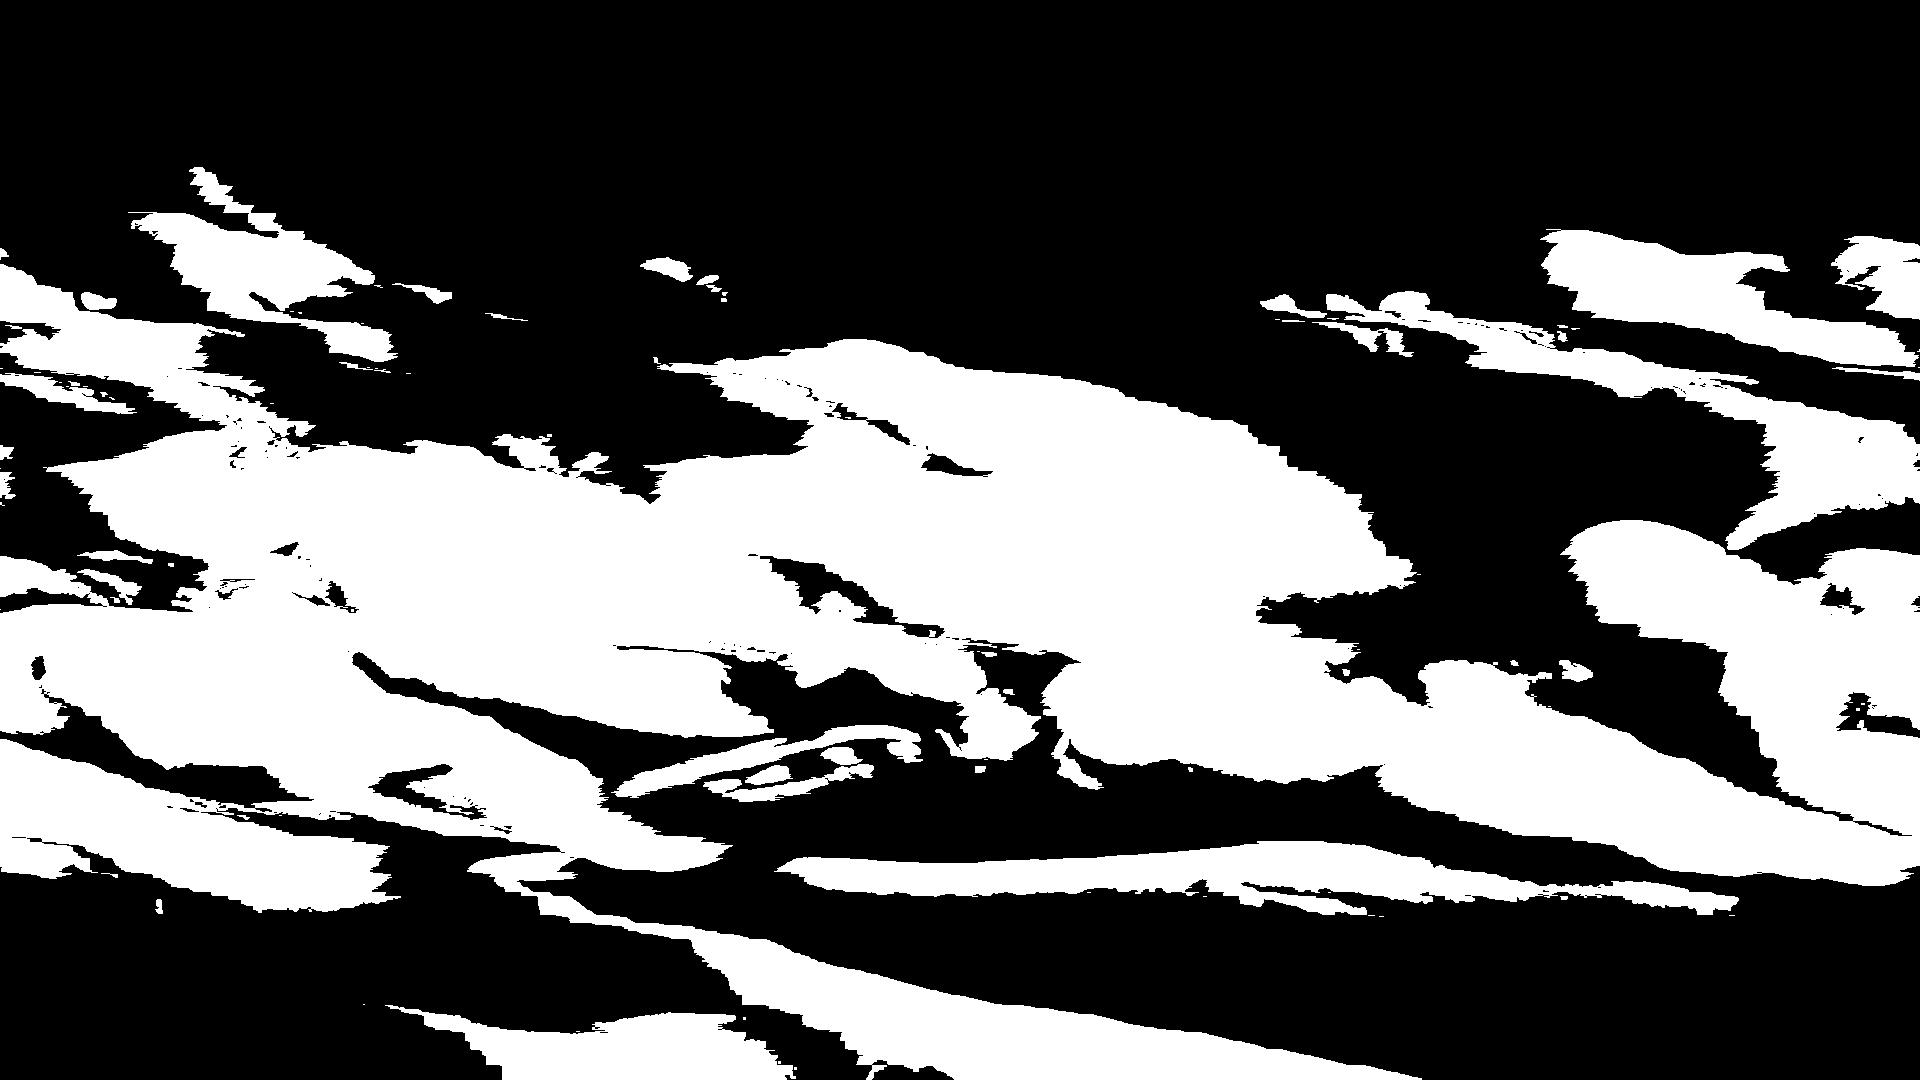

In [7]:
first_dilation = Image.fromarray(np.uint8(out_dma_array), mode='P')
first_dilation

In [8]:
# To save it for comparison later
tempFile = Image.fromarray(np.uint8(first_dilation), mode='P')
tempFile.save('dilaty_broky_peppers.png')

Wait. Hold up. That looks wrong?

Well esteemed reader, you wouldn't be incorrect. The issue at hand is that the image is actually warping across in an unknown fasion (which changes run by run). So, let's implement an image correction feature.

For reasons unknown to us, this issue is not present during simulation, only on the notebook. Therefore, the issue is with the axi-stream somewhere

First, let's analyse our output better:

In [9]:
#here we're going to analyse our output in more depth.

length = 1920*1080
op_1d = np.reshape(out_dma_array, length)
ip_sh = in_dma_array.shape
ip_1d = np.reshape(in_dma_array,ip_sh[0]*ip_sh[1]*ip_sh[2])

In [10]:
# input, for some reason, we have to run this line by line or it hangs
print(np.count_nonzero(np.equal(ip_1d, np.ones(ip_sh[0]*ip_sh[1]*ip_sh[2])*0xF0)))#row start

6444


In [11]:
print(np.count_nonzero(np.equal(ip_1d, np.ones(ip_sh[0]*ip_sh[1]*ip_sh[2])*0xF0)))#row start

6444


In [12]:
print(np.count_nonzero(np.equal(ip_1d, np.ones(ip_sh[0]*ip_sh[1]*ip_sh[2])*0x0F)))#row end

26712


In [13]:
print(np.count_nonzero(np.equal(ip_1d, np.ones(ip_sh[0]*ip_sh[1]*ip_sh[2])*0x0F)))#row end

26712


In [14]:
#output
print(np.count_nonzero(np.equal(op_1d, np.ones(length)*0xF0FF)))#row start

# According to our analysis, the output has disappeared. So let's start again :D

0


In [15]:
print(np.count_nonzero(np.equal(op_1d, np.ones(length)*0xF000)))#row start 

0


In [16]:
print(np.count_nonzero(np.equal(op_1d, np.ones(length)*0x0FFF)))#row end   

0


In [17]:
print(np.count_nonzero(np.equal(op_1d, np.ones(length)*0x0F00)))#row end   

0


In [18]:
blank_img = allocate(shape=(img_size[1],img_size[0]), dtype=np.uint32)
current_row = 0
current_col = 0   

Since we are recreating the image, we are going to use good old maths and matrixs to work out what rows are correct or not. Remember how our bit file is called: "dilation"? Well, surprise, we have injected a parity bit into the end of each row to identify what's a row. 

Just to satisfy the superstitous bunch, please examine the Erosion one first as that goes into a bit of detail about how the issue is consistent.

In [19]:
#iterate through all pixels. Check where it's a row end pixel and grab the index
row_inds = [i for i, x in enumerate(np.vectorize(lambda x: x==0x0FFF or x==0x0F00)(op_1d)) if x]
correct_row_length   = 0
incorrect_row_length = 0
gt =0
lt = 0
sum_of_errors = 0
for i in range(1,len(row_inds)):
    if row_inds[i] - row_inds[i-1] ==1920:
        #correct row length
        correct_row_length +=1
    else:
        incorrect_row_length +=1
        if row_inds[i] - row_inds[i-1] > 1920:
            gt +=1
            sum_of_errors += row_inds[i] - row_inds[i-1]
        else:
            lt +=1
                                      
print("There are ", correct_row_length," correct rows. \n")
print("There are ", incorrect_row_length," incorrect rows. | LESS:",lt,"MORE:",gt,"SUM OF ERRORS:",sum_of_errors, "\n")

There are  0  correct rows. 

There are  0  incorrect rows. | LESS: 0 MORE: 0 SUM OF ERRORS: 0 



Damn, that's a lot of broken. Time to use a cursed algorithm to fix this. The main issue is that rows are not constant length due to the great warp. Therefore, we use interpolation to handle the missing / extra row values.

In [20]:
row_inds_prev = 0
for row in range(0,len(row_inds)):
    row_end_index = row_inds[row]
    
    
    if row_end_index-row_inds_prev != 1920: #error in row length
        
        x = np.linspace(0, 1920, num=row_end_index-row_inds_prev) #intended start, intended end, number of values actually present
        y = op_1d[row_inds_prev:row_end_index] #currnet values for that row
        xnew = np.linspace(0, 1920, num=1920) #intended start, intended end, number of values we want
        #print(len(x),"|",len(y),"|",len(xnew),"\n")
        ynew = np.interp(xnew, x, y) #interpolate using our data into the correct format
        blank_img[row,:] = ynew #write this into an image
    else:    
        blank_img[row,:] =op_1d[row_inds_prev:row_end_index] #correct row length: dont need to interpolate!
    row_inds_prev = row_end_index

And now, for the moment you've all been waiting for,

1,

2,

3,

Ready?

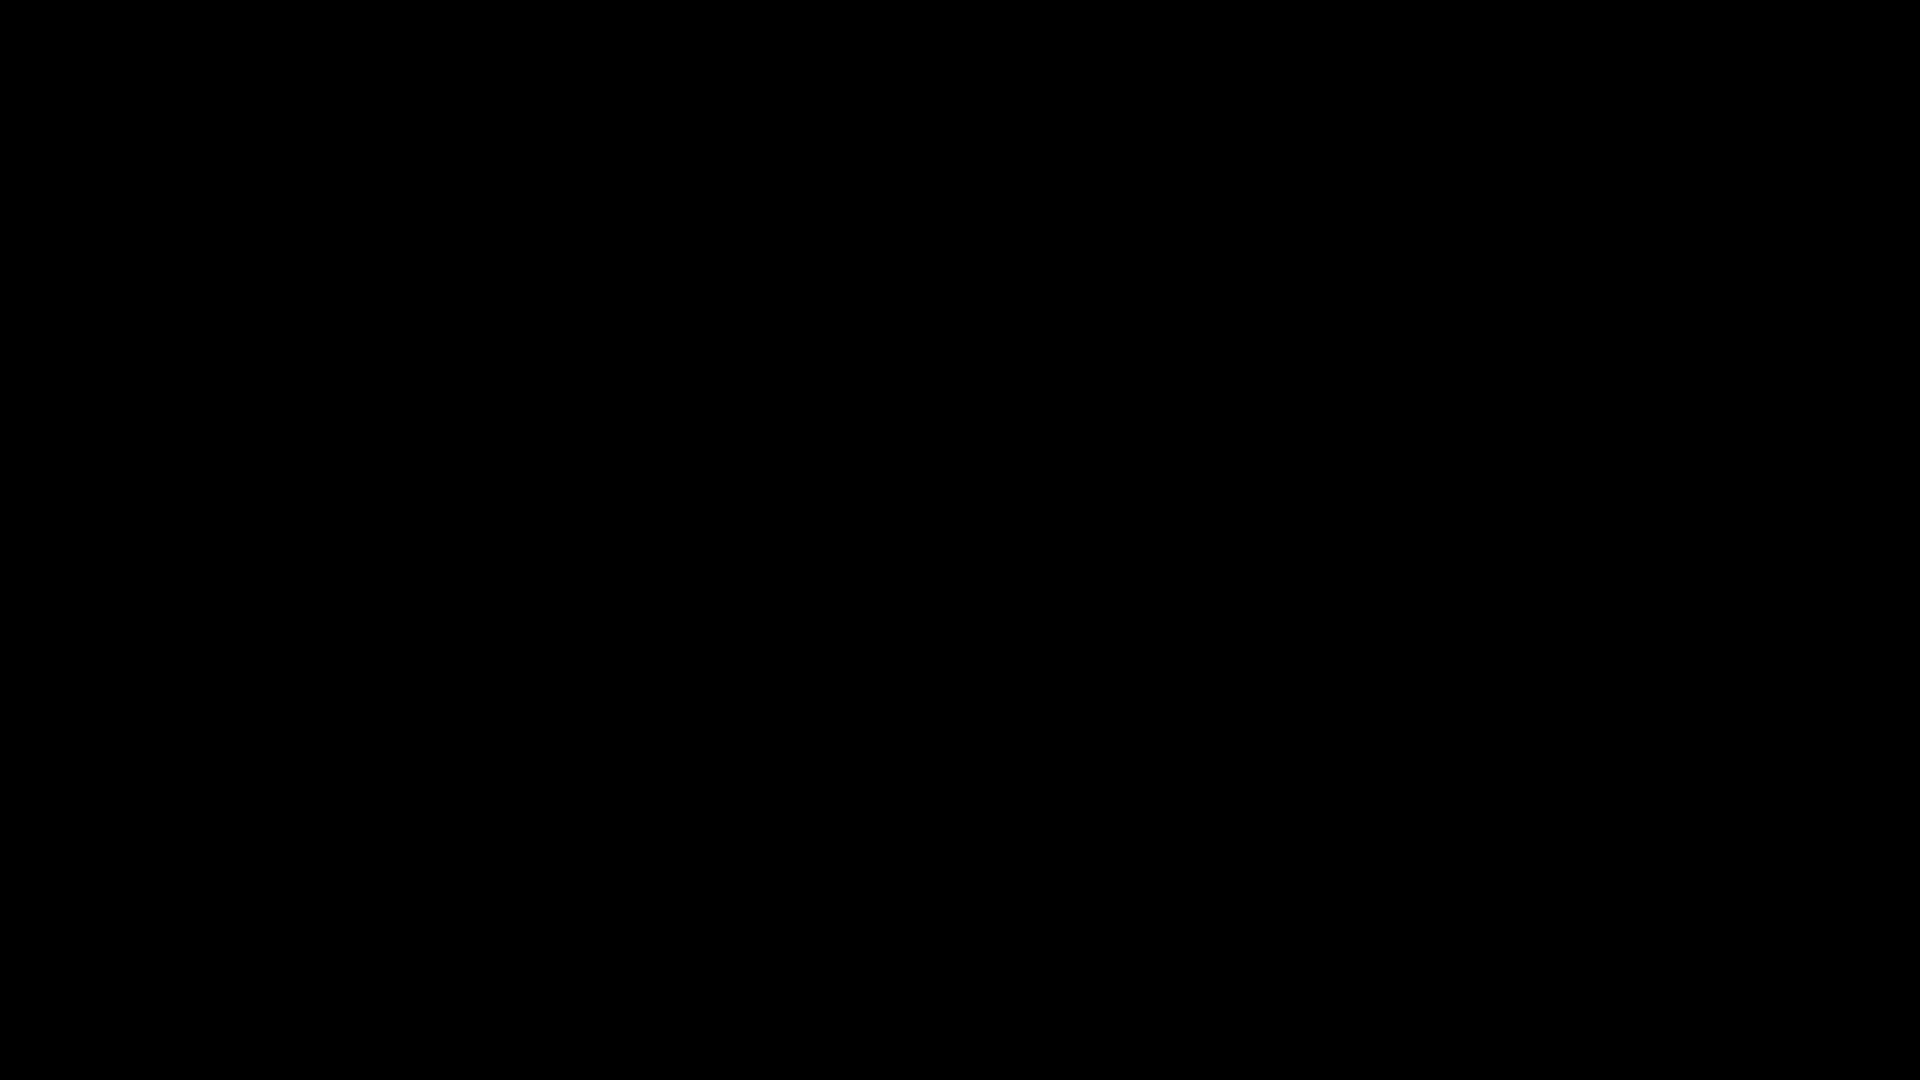

In [21]:
Image.fromarray(np.uint8(blank_img), mode='P')

You know what, it may not be perfect; but a win is a win. Let's save it so that we can compare externally in Windows using network mapping.

## Comparison time

In [ ]:
good_dilate = Image.fromarray(np.uint8(blank_img), mode='P')
good_dilate.save('dilation_peppers.png')

Now, time to directly compare a Computer Vision (CV) result againts our first result:
 
 Pinq is from CV, white is common and green is from first detection.

In [ ]:
cv_dilate = Image.open('CV_dilate .jpg')
# cv_dilate = Image.open('Dilation/CV_dilate.jpg')

cv_dilate_array = np.array(cv_dilate)
first_dilate_array = np.array(first_dilation)

comparison_image = np.dstack((cv_dilate_array, first_dilate_array, cv_dilate_array))

Image.fromarray(np.uint8(comparison_image))

As seen, that is very different. Not ideal, now, let's display how much we've fixed it by using image correction:

Pinq is the first dilate, white is common with the correction in green.

In [ ]:
good_dilate_array = np.array(good_dilate)

comparison_image_correction = np.dstack((first_dilate_array, good_dilate_array, first_dilate_array))

Image.fromarray(np.uint8(comparison_image_correction))

Again, a lot of change. Now, for the finale: let's see how close we are with our corrected to the original.

The pinq is ours, white is common with green as CV implementation.

In [ ]:
comparison_image_final = np.dstack((good_dilate_array, cv_dilate_array, good_dilate_array))

Image.fromarray(np.uint8(comparison_image_final))